# Credit scoring

In this competition we're provided with:
- train and test datasets of 73,799 and 36,349 samples respectivly and 18 features except target one;
- model that we're not allowed to change;
- baseline that gives **ROC_AUC = 0.672**;
- target variable **default** is binary;
- the bank has more not defaulted clients (87% vs 13%) - **sampling is unbalanced**

Our model is **Logistic Regression**. 

It assumes a linear relationship between the variables and the log of the odds.

The best previous model: **roc_auc = 0.745, f1_score = 0.0437**

***We have very pure f1_score. It isn't the key metric but in my opinion is very important in this case.***

What has been done:
1. Worked out **undersampling**:
- 14 tests of model with step by step multyplication of dataset's default part to find the best combination of ROC_AUC and F1_score: plus 700% of all defaults (more than not default) & split with stratify = y (**roc_auc = 0.736, f1_score = 0.7067**)
2. Working out **hyperparameters** for both models (with and without additional default samples):
- LogisticRegressionCV - to find better C for l2 penalty
- GridSearchCV - to find better rest parameters
3. Working out polynomial features: didn't improve the results

What has ben achieved:
- The **best model** (without additional default samples): **roc_auc = 0.745, f1_score = 0.3371**
- ***We still have very pure f1_score. But the key metric is ROC_AUC and it's lower in the model with higher f1_score.***

More details on the features:
- client_id - client ID
- education - level of education
- sex - gender of the borrower
- age - the age of the borrower
- car - car availability flag
- car_type - flag of a foreign car
- decline_app_cnt - the number of rejected past applications
- good_work - flag for having a “good” job
- bki_request_cnt - number of requests in BKI
- home_address - home address categorizer
- work_address - work address categorizer
- income - the borrower's income
- foreign_passport - availability of a foreign passport
- sna - connection of the borrower with the bank's clients
- first_time - the limitation of the availability of information about the borrower
- score_bki - score based on data from the BKI
- region_rating - region rating
- app_date - date of application submission
- default - the default flag on the loan

For data investigation results go to 'Bella K [SF-DST] Credit Scoring EDA&First Model'


In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [28]:
import warnings
warnings.simplefilter('ignore')

from pandas import Series

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')  # beautiful graphs
plt.rcParams['figure.figsize'] = (12, 4)  # figure size

import seaborn as sns
%matplotlib inline

import random
from datetime import datetime, timedelta

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

In [29]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [30]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [31]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [32]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


# DATA

In [33]:
print('Train dataset shape:', df_train.shape)
print('Test dataset shape:', df_test.shape)
print('Submission shape:', sample_submission.shape, end='\n\n')
print(f'Test dataset is {round(df_test.shape[0]/(df_test.shape[0]+df_train.shape[0])*100, 2)}% of the whole dataset')
print(f'Submission is {round(sample_submission.shape[0]/df_test.shape[0]*100, 2)}% of test dataset', end='\n\n')
print('Differences in train and test datasets columns:', list(set(df_train.columns) - set(df_test.columns)), end='\n\n')

print('Train dataset:', end='\n\n')
display(pd.value_counts(df_train.dtypes))
print('\n\nTest dataset:', end='\n\n')
display(pd.value_counts(df_test.dtypes))

Train dataset shape: (73799, 19)
Test dataset shape: (36349, 18)
Submission shape: (24354, 2)

Test dataset is 33.0% of the whole dataset
Submission is 67.0% of test dataset

Differences in train and test datasets columns: ['default']

Train dataset:



int64      12
object      6
float64     1
dtype: int64



Test dataset:



int64      11
object      6
float64     1
dtype: int64

In [34]:
df_train.default.unique()

array([0, 1])

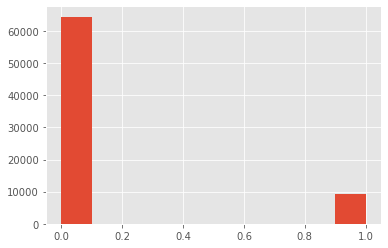

In [35]:
# look at which customers the bank has more: defaulted (1) or not (0)
df_train.default.hist()

In [36]:
df_train.default.value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

1. Target variable **default** is binary.
2. Bank has more not defaulted clients (87% vs 13%) - sampling is unbalanced

In [37]:
df_train.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

## Preprocessing

In [38]:
# DATA

DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')


# fill up gaps in education with Empty for now
df_train.education = df_train.education.fillna('Empty')
df_test.education = df_test.education.fillna('Empty')


# all client_id are unique
df_train.drop('client_id', axis=1, inplace=True)
df_test.drop('client_id', axis=1, inplace=True)


binary_features = ['sex', 'car', 'car_type', 'foreign_passport'] # good_work, default (target)
label_encoder = LabelEncoder()
labels_dict = {}

for col in binary_features:
    df_train[col] = label_encoder.fit_transform(df_train[col])
    df_test[col] = label_encoder.transform(df_test[col])
    labels_dict.setdefault(str(col), dict(enumerate(label_encoder.classes_)))

binary_features = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work'] # default (target)
categorical_features = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
date_features = ['app_date']
numeric_features = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']



# NaNs

df_train['education'] = df_train.apply(lambda x: 'GRD' if x['education']=='Empty' and x['foreign_passport']==1 else ('UGR' if x['education']=='Empty' else x['education']), axis=1)
df_test['education'] = df_test.apply(lambda x: 'GRD' if x['education']=='Empty' and x['foreign_passport']==1 else ('UGR' if x['education']=='Empty' else x['education']), axis=1)

education_code = {'SCH': 1,
                  'UGR': 2,
                  'GRD': 3,
                  'PGR': 4,
                  'ACD': 5
                  }

df_train['education'] = df_train['education'].apply(lambda x: education_code[x])



# Logarithm

cols_for_norm = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

n_col = len(list(df_train.columns))

for col in cols_for_norm:
    df_train['_'.join([col, 'log'])] = df_train[col].apply(lambda x: np.log(x+1))
    
log_features = list(df_train.columns)[n_col:]



# Date

df_train['app_date'] = df_train['app_date'].dropna().apply(lambda x: pd.to_datetime(x))

max_date = max(df_train.app_date.tolist())
df_train['app_date_max_dlt'] = df_train['app_date'].dropna().apply(lambda x: (max_date - x).days)
df_train['app_date_day'] = df_train['app_date'].dropna().apply(lambda x: x.day)
df_train['app_date_month'] = df_train['app_date'].dropna().apply(lambda x: x.month)
df_train['app_date_dow'] = df_train['app_date'].dropna().apply(lambda x: x.dayofweek)
df_train['app_date_w_end'] = df_train['app_date_dow'].dropna().apply(lambda x: 1 if x in [5, 6] else 0)



# Dummy

binary_features.append('app_date_w_end')
categorical_features.extend(['app_date_month', 'app_date_dow'])
numeric_features.extend(['app_date_max_dlt', 'app_date_day'])

X_cat = df_train[categorical_features].values
X_dum = OneHotEncoder(sparse = False).fit_transform(df_train[categorical_features].values)

X_bin = df_train[binary_features].values
X_num = df_train[log_features+['score_bki', 'app_date_max_dlt', 'app_date_day']].values


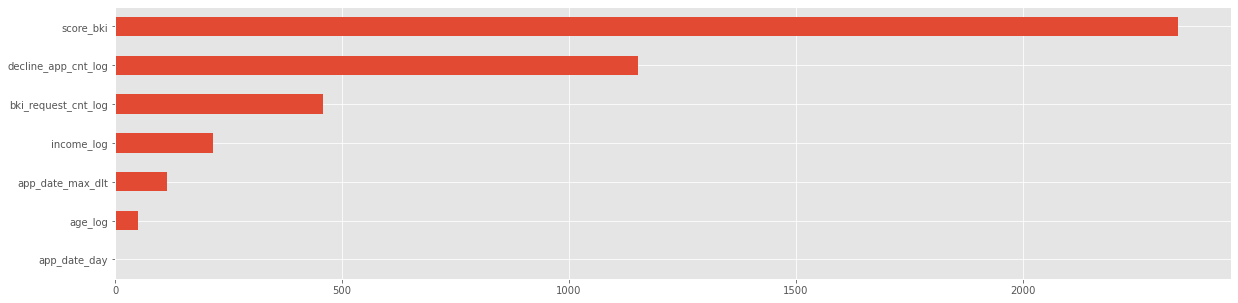

In [39]:
plt.rcParams['figure.figsize'] = (20, 5)
imp_num = Series(f_classif(X_num, df_train['default'])[0], index = log_features+['score_bki', 'app_date_max_dlt', 'app_date_day'])
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

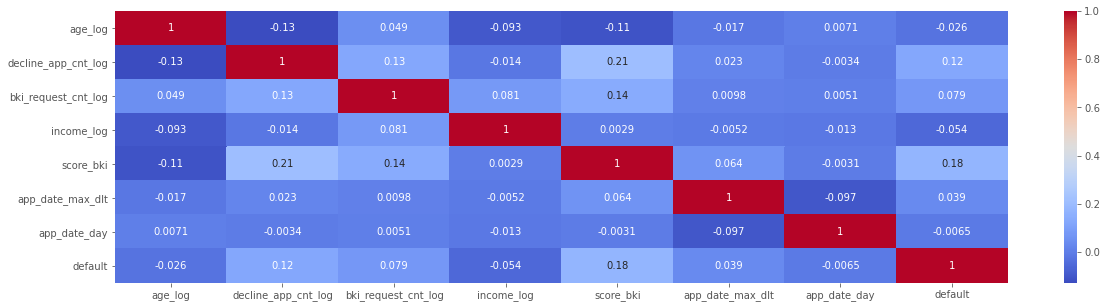

In [40]:
sns.heatmap(pd.concat([df_train[log_features+['score_bki', 'app_date_max_dlt', 'app_date_day']], df_train['default']], axis=1).corr(method="pearson"), 
            annot=True, cmap='coolwarm', )

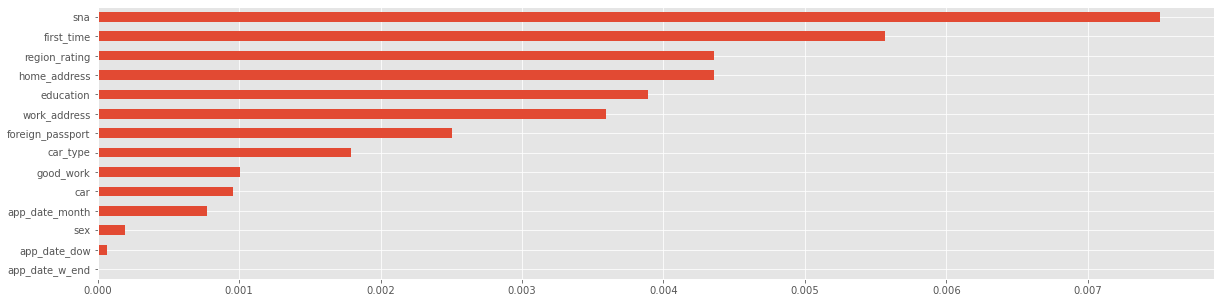

In [41]:
imp_cat = Series(mutual_info_classif(df_train[binary_features + categorical_features], df_train['default'],
                                     discrete_features =True), index = binary_features + categorical_features)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

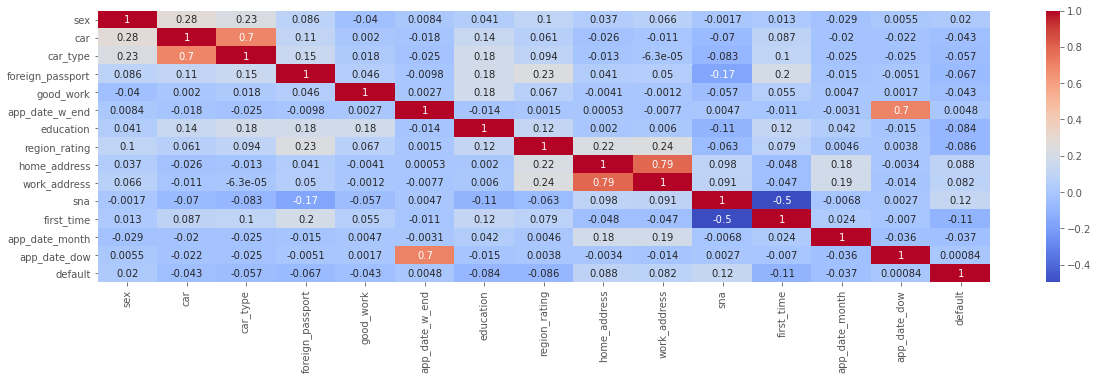

In [42]:
sns.heatmap(pd.concat([df_train[binary_features + categorical_features], df_train['default']], axis=1).corr(method="spearman"), 
            annot=True, cmap='coolwarm', )

# Model

Our first model on raw data:
- roc_auc = 0.584
- f1_score = 0.0
- doesn't recognise any default cases

What to do next:
- fill gaps in education (roc_auc = 0.584)
- logarithm needed features (roc_auc = 0.739, f1_score = 0.0367)
- normalise with logarithm needed features
    - RobustScaer (roc_auc = 0.738, f1_score = 0.0396)
    - StandardScaler (roc_auc = 0.738, f1_score = 0.0396)
- normalise without logarithm needed features
    - RobustScaer (roc_auc = 0.736, f1_score = 0.0394)
    - StandardScaler (roc_auc = 0.736, f1_score = 0.0375)
    -> will try to fix via hyperparameters
- work with correlations
    - with logarithm (roc_auc = 0.735, f1_score = 0.0386)
    -> will try to fix via hyperparameters
- work with outliers
    - without outliers by z-score & logarithm (roc_auc = 0.728, f1_score = 0.0176)
    - max or min without outliers by z-score instead of outliers & logarithm (roc_auc = 0.739, f1_score = 0.0325)
- categorical -> dummy with logarithm (roc_auc = 0.742, f1_score = 0.0427)
- work with dates 
    - categorical -> dummy with logarithm (roc_auc = 0.745, f1_score = 0.0437)
    - split with stratify = y (roc_auc = 0.736, f1_score = 0.0589)


## Undersampling

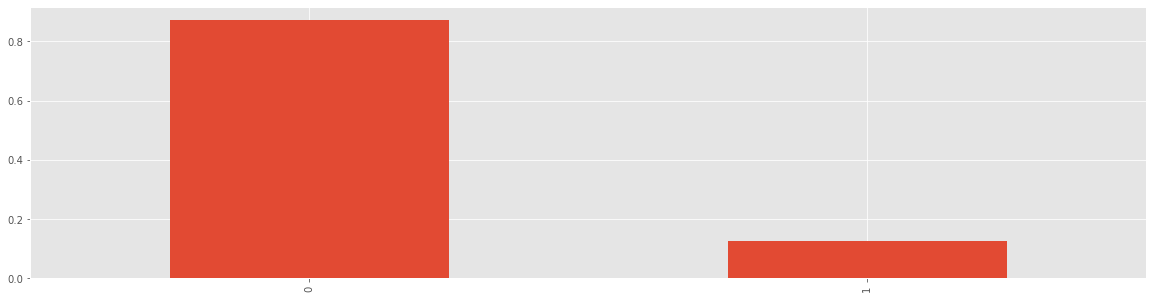

In [43]:
# look at which customers the bank has more: defaulted (1) or not (0)
df_train.default.value_counts(normalize=True).plot.bar()

In [44]:
X = np.hstack([X_num, X_bin, X_dum])
print('X shape:', X.shape, 'X ndim:', X.ndim)
y = df_train['default'].values #copy()
print('y shape:', y.shape, 'y ndim:', y.ndim)

X shape: (73799, 50) X ndim: 2
y shape: (73799,) y ndim: 1


In [45]:
y_new = np.reshape(y, (y.shape[0], 1))
print('y shape:', y_new.shape, 'y ndim:', y_new.ndim)

y shape: (73799, 1) y ndim: 2


In [46]:
X_y = np.hstack([X_num, X_bin, X_dum, y_new])
print('X_y shape:', X_y.shape, 'X_y ndim:', X_y.ndim)

X_y shape: (73799, 51) X_y ndim: 2


In [47]:
print(X_y[:, -1])
print(y)

[0. 0. 0. ... 0. 1. 0.]
[0 0 0 ... 0 1 0]


In [48]:
# Define the column index to filter by
column_index = -1

# Define the value to filter for
value_to_filter = 1

# Filter the matrix based on the value in the specified column
X_y_default = X_y[X_y[:, column_index] == value_to_filter]
X_y_default[:, -1]

array([1., 1., 1., ..., 1., 1., 1.])

In [49]:
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [50]:
models_dict = {}

for i in range(1, 15):
    # Define the number of times to vertically stack the matrix
    #num_stacks = i
    # Create multiple copies of the matrix using np.tile()
    stacked_X_y_default = np.tile(X_y_default, (i, 1))
    X_y_enlarge = np.vstack([X_y, stacked_X_y_default])
    #print('X_y_enlarge shape:', X_y_enlarge.shape, end='\n\n')
    #print('Not Default samples count:', df_train.default.value_counts()[0])
    #print('Default samples count:', df_train.default.value_counts()[1] * i, end='\n\n')
    print(f'Plus {i*100}% of all default samples')
    
    X_enlarge = X_y_enlarge[:, :-1]
    y_enlarge = X_y_enlarge[:, -1]
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_enlarge, y_enlarge, test_size=0.20, 
                                                          stratify=y_enlarge, random_state=42)
    model_1 = LogisticRegression()
    model_1.fit(X_train, y_train)

    y_pred_prob = model_1.predict_proba(X_valid)[:,1]
    y_pred = model_1.predict(X_valid)
    
    conf_mat = confusion_matrix(y_valid, y_pred).T
    TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]
    
    print('ROC AUC: %0.3f' % roc_auc_score(y_valid, y_pred_prob))
    print('F1: %.4f' % f1_score(y_valid, y_pred), end='\n\n')
    
    models_dict.setdefault(f'Plus {i*100}%', 
                                {'Not Default': df_train.default.value_counts()[0],
                                 'Default': df_train.default.value_counts()[1] * i,
                                 'Default %': round(df_train.default.value_counts()[1] * i / (df_train.default.value_counts()[1] * i + df_train.default.value_counts()[0]), 2),
                                 'Precision': round(precision_score(y_valid, y_pred), 3),
                                 'Recall': round(recall_score(y_valid, y_pred), 3),
                                 'TP Rate': round(TP / (TP + FN), 3),
                                 'FP Rate': round(FP / (TN + FP), 3),
                                 'ROC AUC': round(roc_auc_score(y_valid, y_pred_prob), 3),
                                 'F1': round(f1_score(y_valid, y_pred), 4)}
                            )

Plus 100% of all default samples
ROC AUC: 0.740
F1: 0.2390

Plus 200% of all default samples
ROC AUC: 0.736
F1: 0.4093

Plus 300% of all default samples
ROC AUC: 0.735
F1: 0.5084

Plus 400% of all default samples
ROC AUC: 0.735
F1: 0.5779

Plus 500% of all default samples
ROC AUC: 0.735
F1: 0.6343

Plus 600% of all default samples
ROC AUC: 0.735
F1: 0.6731

Plus 700% of all default samples
ROC AUC: 0.736
F1: 0.7067

Plus 800% of all default samples
ROC AUC: 0.734
F1: 0.7312

Plus 900% of all default samples
ROC AUC: 0.734
F1: 0.7536

Plus 1000% of all default samples
ROC AUC: 0.734
F1: 0.7733

Plus 1100% of all default samples
ROC AUC: 0.735
F1: 0.7897

Plus 1200% of all default samples
ROC AUC: 0.735
F1: 0.8038

Plus 1300% of all default samples
ROC AUC: 0.735
F1: 0.8147

Plus 1400% of all default samples
ROC AUC: 0.734
F1: 0.8256



In [51]:
models_df = pd.DataFrame.from_dict(models_dict, orient='index')
models_df

,Not Default,Default,Default %,Precision,Recall,TP Rate,FP Rate,ROC AUC,F1
Plus 100%,64427,9372,0.13,0.559,0.152,0.152,0.035,0.740,0.2390
Plus 200%,64427,18744,0.23,0.608,0.308,0.308,0.087,0.736,0.4093
Plus 300%,64427,28116,0.30,0.624,0.429,0.429,0.150,0.735,0.5084
Plus 400%,64427,37488,0.37,0.642,0.526,0.526,0.213,0.735,0.5779
Plus 500%,64427,46860,0.42,0.656,0.614,0.614,0.281,0.735,0.6343
Plus 600%,64427,56232,0.47,0.672,0.674,0.674,0.335,0.735,0.6731
Plus 700%,64427,65604,0.50,0.686,0.729,0.729,0.388,0.736,0.7067
Plus 800%,64427,74976,0.54,0.696,0.771,0.771,0.441,0.734,0.7312
Plus 900%,64427,84348,0.57,0.707,0.806,0.806,0.485,0.734,0.7536
Plus 1000%,64427,93720,0.59,0.717,0.839,0.839,0.529,0.734,0.7733


Previous best model: roc_auc = 0.745, f1_score = 0.0437

Work with undersampling:
- plus 50% of all defaults (roc_auc = 0.738, f1_score = 0.1406)
- plus 50% of all defaults & split with stratify = y (roc_auc = 0.733, f1_score = 0.1494)
- plus 100% of all defaults (roc_auc = 0.745, f1_score = 0.2483)      !!!!!!!!!!!!! the best **roc_auc** for now
- plus 200% of all defaults (roc_auc = 0.731, f1_score = 0.3985)
- plus 200% of all defaults  & split with stratify = y (roc_auc = 0.736, f1_score = 0.4093)
- plus 700% of all defaults (more than not default) & split with stratify = y (roc_auc = 0.736, f1_score = 0.7067)       !!!!!!!!!!!!!! the best **roc_auc & f1_score** for now
- plus 1400% of all defaults (more than not default) & split with stratify = y (roc_auc = 0.734, f1_score = 0.8256)

In [52]:
def get_roc_auc(X, y, model):
    y_pred_prob = model.predict_proba(X)[:,1]
    y_pred = model.predict(X)

    fpr, tpr, threshold = roc_curve(y, y_pred_prob)
    roc_auc = roc_auc_score(y, y_pred_prob)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    print('F1: %.4f' % f1_score(y, y_pred))
    
    conf_mat = pd.DataFrame(confusion_matrix(y, y_pred).T)
    display(conf_mat)
    
    conf_mat = confusion_matrix(y, y_pred).T
    TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]
    print('Precision', round(precision_score(y, y_pred), 3))
    print('Recall', round(recall_score(y, y_pred), 3))
    print('TP Rate', round(TP / (TP + FN), 3))
    print('FP Rate', round(FP / (TN + FP), 3))
    

    
from sklearn.model_selection import cross_validate

def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] f1_score = {:.4f} +/- {:.4f}'.format(avg_f1_train, std_f1_train))
    print('[valid] f1_score = {:.4f} +/- {:.4f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('f1_score', fontsize=15)
    plt.legend(fontsize=15)
    

## model 1

In [53]:
# the best for now
# binary_features + categorical_features (dummy) + log_features + ['score_bki', 'app_date_max_dlt', 'app_date_day']
#X = np.hstack([X_num_log, X_num_oth, X_bin, X_dum])
#y = df_train['default'].copy()

stacked_X_y_default = np.tile(X_y_default, (7, 1))
X_y_enlarge = np.vstack([X_y, stacked_X_y_default])

X_enlarge = X_y_enlarge[:, :-1]
y_enlarge = X_y_enlarge[:, -1]

X_1 = X_enlarge.copy()
print('X shape:', X_1.shape)
y_1 = y_enlarge.copy()
print('y shape:', y_1.shape)

# X shape: (73799, 16)
# y shape: (73799,)

X shape: (139403, 50)
y shape: (139403,)


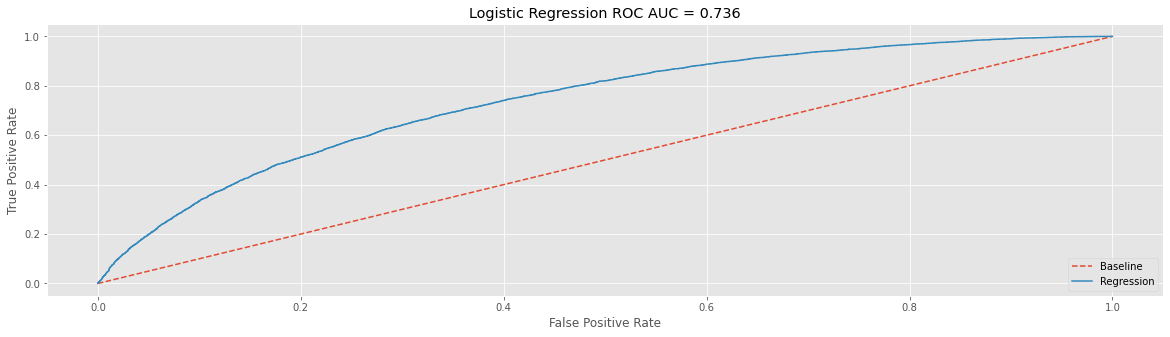

F1: 0.7067


,0,1
0,7882,4068
1,5004,10927


Precision 0.686
Recall 0.729
TP Rate 0.729
FP Rate 0.388


In [54]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(X_1, y_1, test_size=0.20, stratify=y_1, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

model_1 = LogisticRegression()
model_1.fit(X_train_1, y_train_1)

get_roc_auc(X_valid_1, y_valid_1, model_1)

In [55]:
model_1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The share of positive results among "bad" borrowers (truly positive results) is the sensitivity of the model, that is, the ability of the model to correctly identify "bad" borrowers and minimize losses associated with issuing a loan to a "bad" client.

The proportion of negative results among "good" borrowers (truly negative results) is the specificity of the model (Specificity). Here we are already talking about the ability of the model to correctly identify "good" borrowers and minimize losses associated with the refusal to issue a loan to a bona fide client.

The F1 score is a metric commonly used in classification tasks to evaluate the model's performance. It combines precision and recall into a single value, providing a balanced measure of the model's accuracy.

The F1 score is calculated based on the precision (P) and recall (R) values, which are defined as follows:

Precision (P) = True Positives / (True Positives + False Positives) - Defaults

Recall (R) = True Positives / (True Positives + False Negatives)

The F1 score is then computed as the harmonic mean of precision and recall:

F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

The F1 score ranges between 0 and 1, with 1 being the best possible value. A higher F1 score indicates better model performance in terms of both precision and recall.

When interpreting the F1 score, consider the following:
1. Balance between Precision and Recall: The F1 score gives equal weight to precision and recall, which means it provides a balanced assessment of the model's performance in terms of correctly identifying positive instances (precision) and capturing all positive instances (recall).
2. Higher is Better: A higher F1 score indicates better model performance. A score of 1 means perfect precision and recall, while a score close to 0 indicates poor performance.
3. Task-dependent Interpretation: The interpretation of the F1 score may vary depending on the specific classification task and its requirements. For example, in a medical diagnosis scenario, where false negatives (missed positive cases) are more critical, a higher recall (and thus, a higher F1 score) might be more desirable.
4. Compare F1 scores: When comparing different models or configurations, it's helpful to look at their respective F1 scores. The model with a higher F1 score is generally considered to have better overall performance.

In summary, the F1 score provides a balanced assessment of a classification model's performance by considering both precision and recall. It's a useful metric for evaluating and comparing models, especially when the dataset is imbalanced or when false positives and false negatives have different levels of impact in the specific task.


[train] f1_score = 0.7063 +/- 0.0005
[valid] f1_score = 0.7060 +/- 0.0018


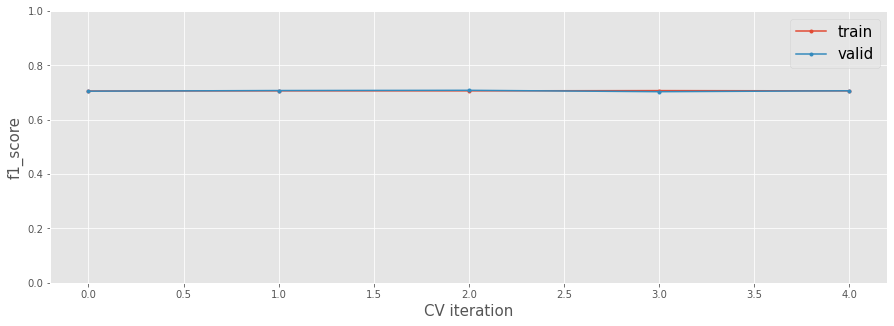

In [56]:
cv_metrics = cross_validate(model_1, X_1, y_1, cv=5, scoring='f1', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)

### Hyperparameters

Each of the values in Cs describes the inverse of regularization strength. If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. Like in support vector machines, smaller values specify stronger regularization.

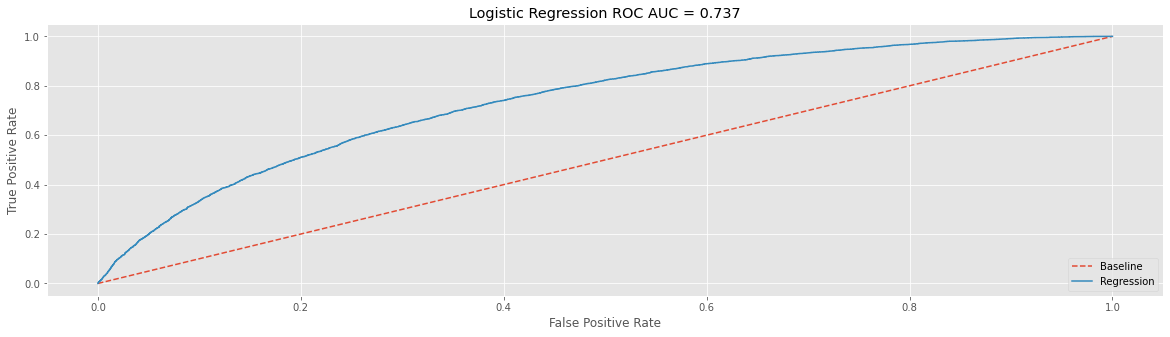

F1: 0.7085


,0,1
0,7870,4017
1,5016,10978


Precision 0.686
Recall 0.732
TP Rate 0.732
FP Rate 0.389


Best C: [2.7825594]


In [57]:
model_1_cv = LogisticRegressionCV(cv=5)
model_1_cv.fit(X_train_1, y_train_1)

get_roc_auc(X_valid_1, y_valid_1, model_1_cv)
print('\n\nBest C:', model_1_cv.C_) # Array of C that maps to the best scores across every class.

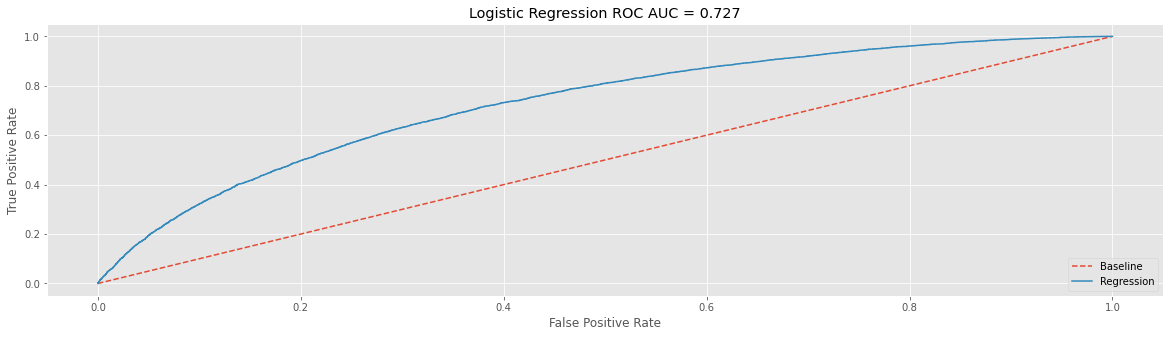

F1: 0.7155


,0,1
0,7072,3403
1,5814,11592


Precision 0.666
Recall 0.773
TP Rate 0.773
FP Rate 0.451


Best C: [0.0001]


In [58]:
model_1_cv_sc = LogisticRegressionCV(cv=5, scoring='f1')
model_1_cv_sc.fit(X_train_1, y_train_1)

get_roc_auc(X_valid_1, y_valid_1, model_1_cv_sc)
print('\n\nBest C:', model_1_cv_sc.C_) # Array of C that maps to the best scores across every class.

In [59]:
# Let's find the optimal value of the regularization parameter for logistic regression.
# search for GridSearchCV hyperparameters by iterating through the parameters on the grid followed by cross-validation
# running GridSearch on a small number of iterations max_iter=50 and with a sufficiently large stop delta tol1e-3
# to get the optimal parameters of the model in the first approximation

model_1_gscv = LogisticRegression(random_state=42)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'C': [model_1_cv.C_[0]],
     'penalty': ['l1'], 
     'solver': ['liblinear' 'saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_1_cv.C_[0]],
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_1_cv.C_[0]],
     'penalty': ['elasticnet'], 
     'solver': ['saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_1_cv.C_[0]],
     'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model_1_gscv, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train_1, y_train_1)

best_model = gridsearch.best_estimator_
best_parameters = best_model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

y_pred_1 = best_model.predict(X_valid_1)
conf_mat = confusion_matrix(y_valid_1, y_pred_1).T
TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]

print('Accuracy: %.4f' % accuracy_score(y_valid_1, y_pred_1))
print('Precision: %.4f' % precision_score(y_valid_1, y_pred_1))
print('Recall: %.4f' % recall_score(y_valid_1, y_pred_1))
print('F1: %.4f' % f1_score(y_valid_1, y_pred_1))
print('FP Rate: %.4f' % (FP / (TN + FP)))

	C: 2.782559402207126
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6763
Precision: 0.6865
Recall: 0.7328
F1: 0.7089
FP Rate: 0.3894


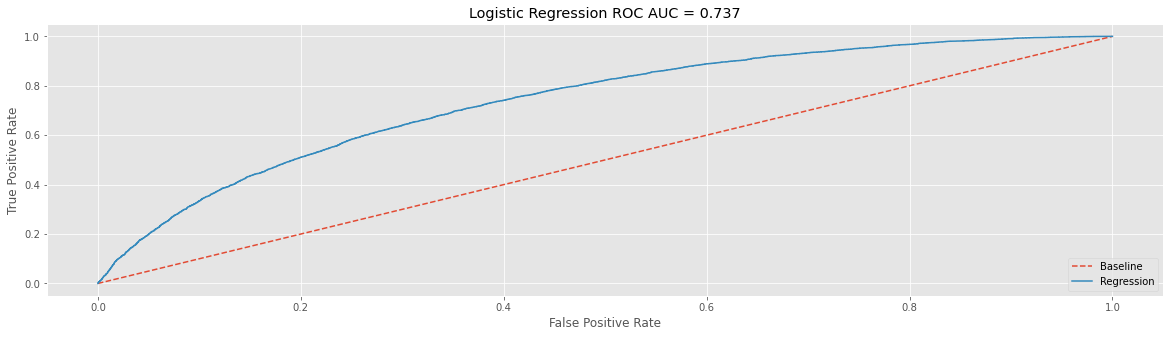

F1: 0.7089


,0,1
0,7868,4007
1,5018,10988


Precision 0.686
Recall 0.733
TP Rate 0.733
FP Rate 0.389


In [60]:
model_1_bp = LogisticRegression(C=model_1_cv.C_[0],
                                penalty='l2',
                                tol=0.001, 
                                fit_intercept=True, 
                                intercept_scaling=1, 
                                class_weight='none', 
                                random_state=None, 
                                solver='newton-cg', 
                                max_iter=100, 
                                multi_class='auto', 
                                verbose=0, 
                                warm_start=False, 
                                n_jobs=None, 
                                l1_ratio=None
                               )

model_1_bp.fit(X_train_1, y_train_1)

get_roc_auc(X_valid_1, y_valid_1, model_1_bp)

In [61]:
model_1_gscv_c = LogisticRegression(random_state=42)
iter_ = 50
param_grid = [
    {'C': np.logspace(0, 4, 10),
     'penalty': ['l2'],
     'tol': [0.001], 
     'class_weight': ['none'], 
     'solver': ['newton-cg'], 
     'max_iter': [iter_], 
     'multi_class': ['auto'], 
     },
]

gridsearch = GridSearchCV(model_1_gscv_c, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train_1, y_train_1)

best_model_c = gridsearch.best_estimator_
best_parameters = best_model_c.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

y_pred_1 = best_model_c.predict(X_valid_1)
conf_mat = confusion_matrix(y_valid_1, y_pred_1).T
TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]

print('Accuracy: %.4f' % accuracy_score(y_valid_1, y_pred_1))
print('Precision: %.4f' % precision_score(y_valid_1, y_pred_1))
print('Recall: %.4f' % recall_score(y_valid_1, y_pred_1))
print('F1: %.4f' % f1_score(y_valid_1, y_pred_1))
print('FP Rate: %.4f' % (FP / (TN + FP)))

	C: 7.742636826811269
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6763
Precision: 0.6865
Recall: 0.7328
F1: 0.7089
FP Rate: 0.3894


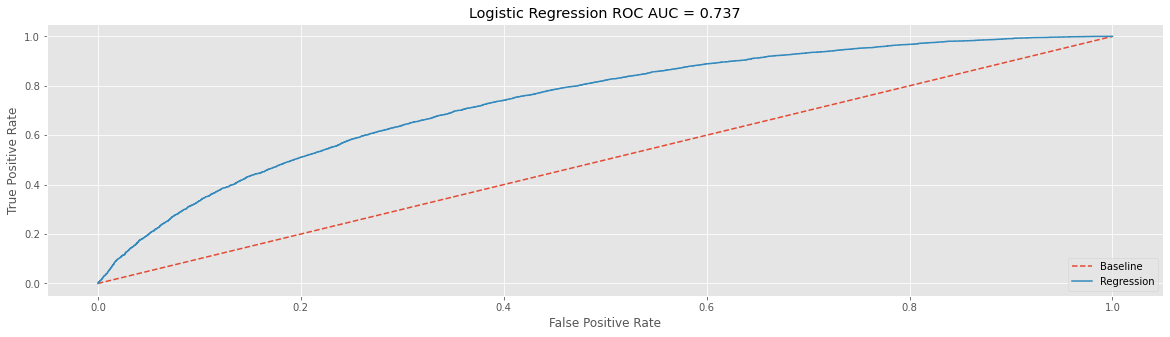

F1: 0.7089


,0,1
0,7868,4007
1,5018,10988


Precision 0.686
Recall 0.733
TP Rate 0.733
FP Rate 0.389


In [62]:
model_1_bp_c = LogisticRegression(C=7.742636826811269,
                                  penalty='l2',
                                  tol=0.001, 
                                  fit_intercept=True, 
                                  intercept_scaling=1, 
                                  class_weight='none', 
                                  random_state=None, 
                                  solver='newton-cg', 
                                  max_iter=100, 
                                  multi_class='auto', 
                                  verbose=0, 
                                  warm_start=False, 
                                  n_jobs=None, 
                                  l1_ratio=None
                                 )

model_1_bp_c.fit(X_train_1, y_train_1)

get_roc_auc(X_valid_1, y_valid_1, model_1_bp_c)

## model 0

In [63]:
#X = df_train.copy().select_dtypes(include='number').drop('default', axis=1)
#X = df_train[binary_features+categorical_features+norm_features+['default']].copy().select_dtypes(include='number').drop('default', axis=1)
#X = df_train[binary_features+categorical_features+log_features+['score_bki', 'default']].copy().select_dtypes(include='number').drop(['home_address', 'car', 'first_time', 'default'], axis=1)
#X = df_wo_otl[binary_features+categorical_features+log_features+['score_bki', 'default']].copy().select_dtypes(include='number').drop('default', axis=1)
#X = df_train[col_for_model].copy().select_dtypes(include='number').drop('default', axis=1)

# the best for now
# binary_features + categorical_features (dummy) + log_features + ['bki_score_ss', 'app_date_max_dlt', 'app_date_day']
X_0 = np.hstack([X_num, X_bin, X_dum])

print('X shape:', X_0.shape)
y_0 = df_train['default'].copy()
print('y shape:', y_0.shape)

# X shape: (73799, 16 -> 50)
# y shape: (73799,)

X shape: (73799, 50)
y shape: (73799,)


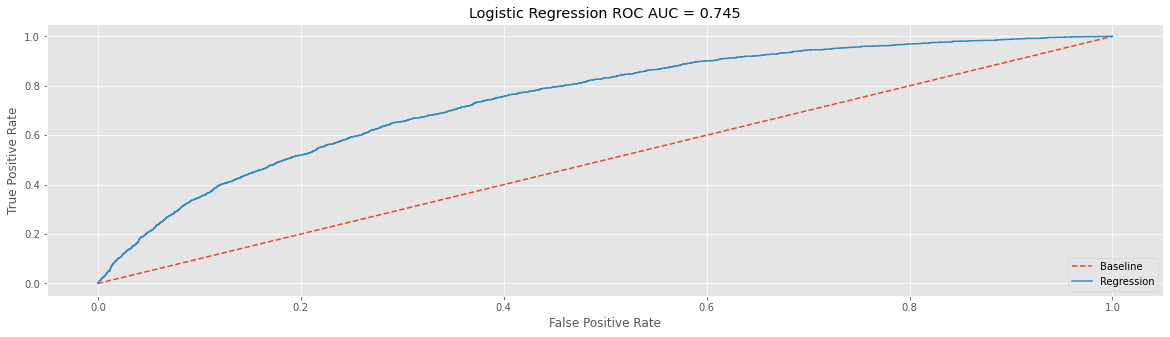

F1: 0.0417


,0,1
0,12880,1787
1,53,40


Precision 0.43
Recall 0.022
TP Rate 0.022
FP Rate 0.004


In [64]:
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(X_0, y_0, test_size=0.20, random_state=42)

model_0 = LogisticRegression()
model_0.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0)

In [65]:
model_0.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

[train] f1_score = 0.0552 +/- 0.0047
[valid] f1_score = 0.0540 +/- 0.0054


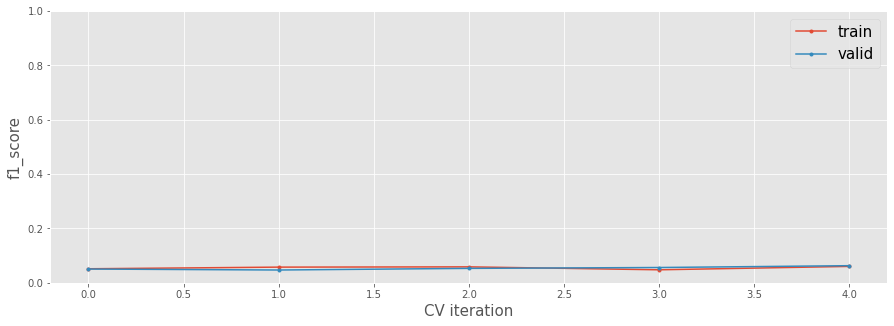

In [66]:
cv_metrics = cross_validate(model_0, X_0, y_0, cv=5, scoring='f1', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)

[train] f1_score = 0.7359 +/- 0.0021
[valid] f1_score = 0.7343 +/- 0.0081


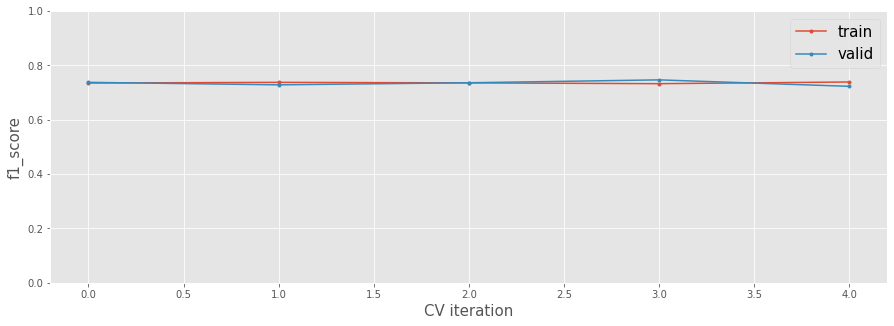

In [67]:
cv_metrics = cross_validate(model_0, X_0, y_0, cv=5, scoring='roc_auc', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)

### Hyperparameters

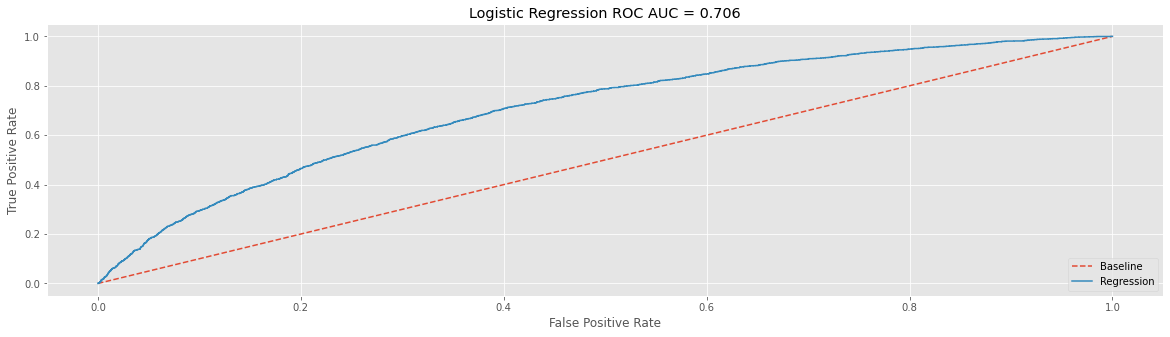

F1: 0.0000


,0,1
0,12933,1827
1,0,0


Precision 0.0
Recall 0.0
TP Rate 0.0
FP Rate 0.0


Best C: [0.0001]


In [68]:
model_0_cv = LogisticRegressionCV(cv=5)
model_0_cv.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0_cv)
print('\n\nBest C:', model_0_cv.C_) # Array of C that maps to the best scores across every class.

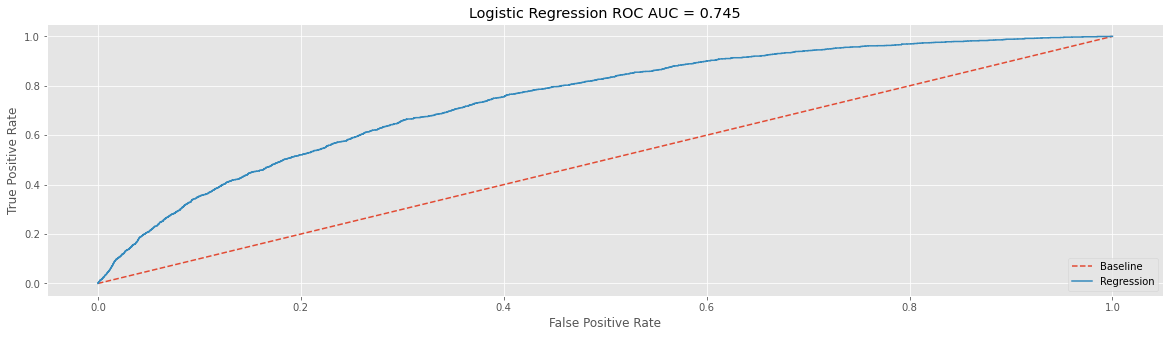

F1: 0.0464


,0,1
0,12865,1782
1,68,45


Precision 0.398
Recall 0.025
TP Rate 0.025
FP Rate 0.005


Best C: [2.7825594]


In [69]:
model_0_cv_sc = LogisticRegressionCV(cv=5, scoring='roc_auc')
model_0_cv_sc.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0_cv_sc)
print('\n\nBest C:', model_0_cv_sc.C_) # Array of C that maps to the best scores across every class.

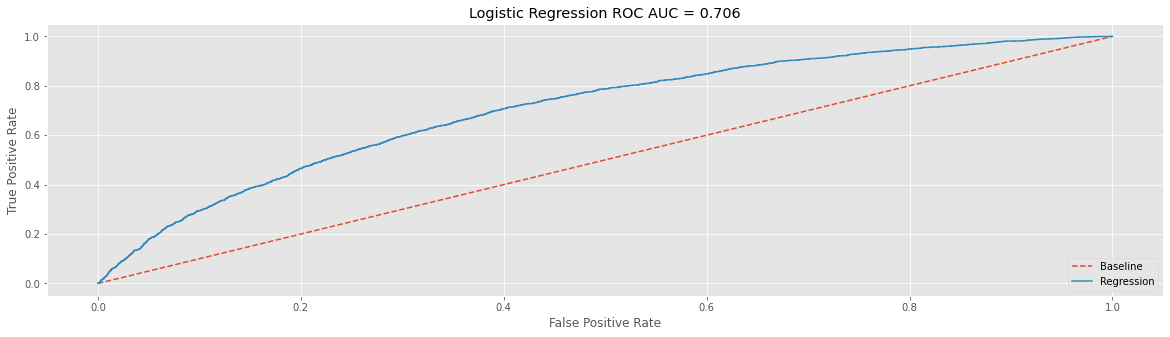

F1: 0.0000


,0,1
0,12933,1827
1,0,0


Precision 0.0
Recall 0.0
TP Rate 0.0
FP Rate 0.0


In [70]:
model_0_c = LogisticRegression(C=model_0_cv.C_[0])
model_0_c.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0_c)

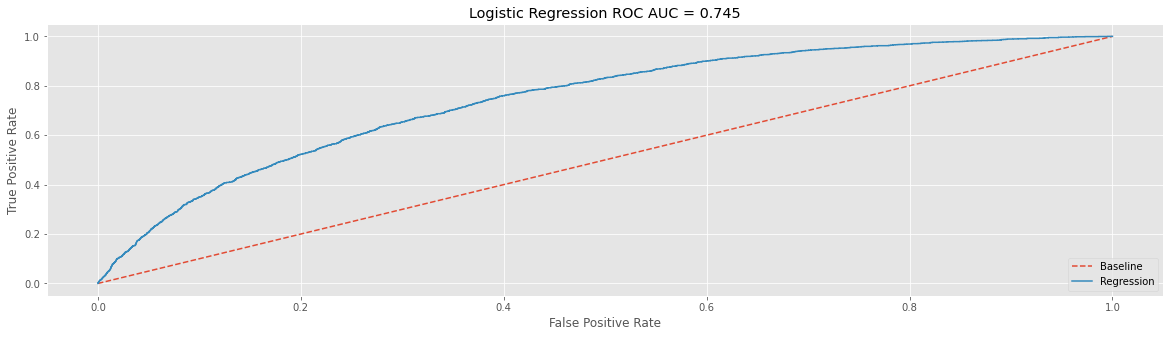

F1: 0.0445


,0,1
0,12872,1784
1,61,43


Precision 0.413
Recall 0.024
TP Rate 0.024
FP Rate 0.005


In [71]:
model_0_sc_c = LogisticRegression(C=model_0_cv_sc.C_[0])
model_0_sc_c.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0_sc_c)

In [72]:
# Let's find the optimal value of the regularization parameter for logistic regression.
# search for GridSearchCV hyperparameters by iterating through the parameters on the grid followed by cross-validation
# running GridSearch on a small number of iterations max_iter=50 and with a sufficiently large stop delta tol1e-3
# to get the optimal parameters of the model in the first approximation
model_0_gscv = LogisticRegression(random_state=42)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'C': [model_0_cv_sc.C_[0]],
     'penalty': ['l1'], 
     'solver': ['liblinear' 'saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_0_cv_sc.C_[0]],
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_0_cv_sc.C_[0]],
     'penalty': ['elasticnet'], 
     'solver': ['saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_0_cv_sc.C_[0]],
     'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model_0_gscv, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train_0, y_train_0)

best_model = gridsearch.best_estimator_
best_parameters = best_model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

y_pred_0 = best_model.predict(X_valid_0)
conf_mat = confusion_matrix(y_valid_0, y_pred_0).T
TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]

print('Accuracy: %.4f' % accuracy_score(y_valid_0, y_pred_0))
print('Precision: %.4f' % precision_score(y_valid_0, y_pred_0))
print('Recall: %.4f' % recall_score(y_valid_0, y_pred_0))
print('F1: %.4f' % f1_score(y_valid_0, y_pred_0))
print('FP Rate: %.4f' % (FP / (TN + FP)))


	C: 2.782559402207126
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6692
Precision: 0.2241
Recall: 0.6793
F1: 0.3370
FP Rate: 0.3322


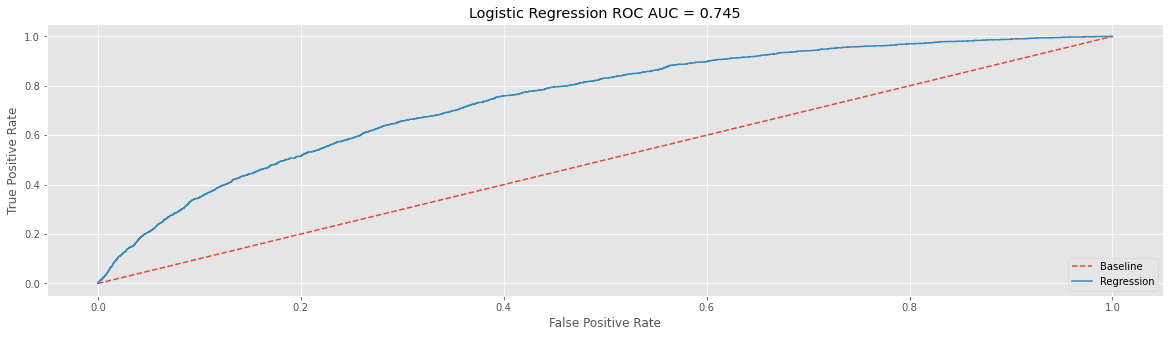

F1: 0.3371


,0,1
0,8638,586
1,4295,1241


Precision 0.224
Recall 0.679
TP Rate 0.679
FP Rate 0.332


In [73]:
model_0_bp = LogisticRegression(C=model_0_cv_sc.C_[0], # 0.3593813663804626
                                penalty='l2',
                                tol=0.001, 
                                fit_intercept=True, 
                                intercept_scaling=1, 
                                class_weight='balanced', 
                                random_state=None, 
                                solver='newton-cg', 
                                max_iter=100, 
                                multi_class='auto', 
                                verbose=0, 
                                warm_start=False, 
                                n_jobs=None, 
                                l1_ratio=None
                               )

model_0_bp.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0_bp)

In [74]:
model_0_gscv = LogisticRegression(random_state=42)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'C': [model_0_cv.C_[0]],
     'penalty': ['l1'], 
     'solver': ['liblinear' 'saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_0_cv.C_[0]],
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_0_cv.C_[0]],
     'penalty': ['elasticnet'], 
     'solver': ['saga'], 
     'class_weight': ['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter': [iter_],
     'tol': [epsilon_stop]},
    {'C': [model_0_cv.C_[0]],
     'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model_0_gscv, param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
gridsearch.fit(X_train_0, y_train_0)

best_model = gridsearch.best_estimator_
best_parameters = best_model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

y_pred_0 = best_model.predict(X_valid_0)
conf_mat = confusion_matrix(y_valid_0, y_pred_0).T
TN, FN, FP, TP = conf_mat[0][0], conf_mat[0][1], conf_mat[1][0], conf_mat[1][1]

print('Accuracy: %.4f' % accuracy_score(y_valid_0, y_pred_0))
print('Precision: %.4f' % precision_score(y_valid_0, y_pred_0))
print('Recall: %.4f' % recall_score(y_valid_0, y_pred_0))
print('F1: %.4f' % f1_score(y_valid_0, y_pred_0))
print('FP Rate: %.4f' % (FP / (TN + FP)))


	C: 0.0001
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6693
Precision: 0.2242
Recall: 0.6793
F1: 0.3371
FP Rate: 0.3321


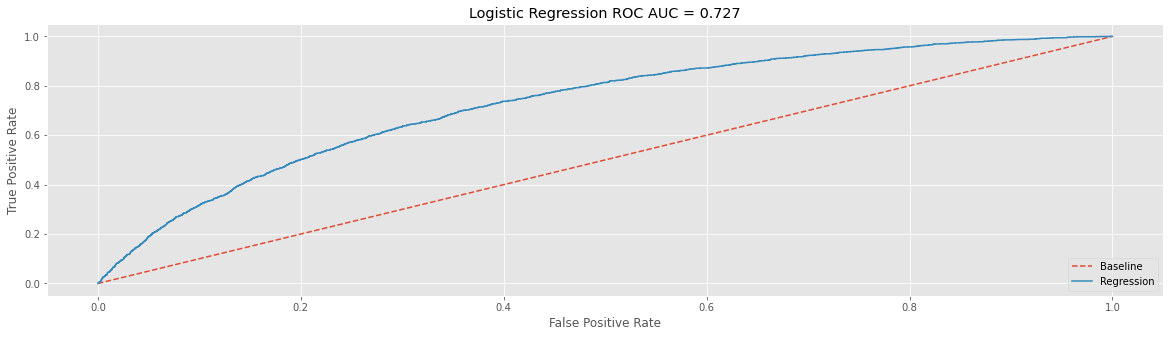

F1: 0.3295


,0,1
0,8584,609
1,4349,1218


Precision 0.219
Recall 0.667
TP Rate 0.667
FP Rate 0.336


In [75]:
model_0_bp_cv = LogisticRegression(C=model_0_cv.C_[0], # 0.000774263682681127
                                   penalty='l2',
                                   tol=0.001, 
                                   fit_intercept=True, 
                                   intercept_scaling=1, 
                                   class_weight='balanced', 
                                   random_state=None, 
                                   solver='newton-cg', 
                                   max_iter=100, 
                                   multi_class='auto', 
                                   verbose=0, 
                                   warm_start=False, 
                                   n_jobs=None, 
                                   l1_ratio=None
                                  )

model_0_bp_cv.fit(X_train_0, y_train_0)

get_roc_auc(X_valid_0, y_valid_0, model_0_bp_cv)

[train] f1_score = 0.3336 +/- 0.0005
[valid] f1_score = 0.3331 +/- 0.0075


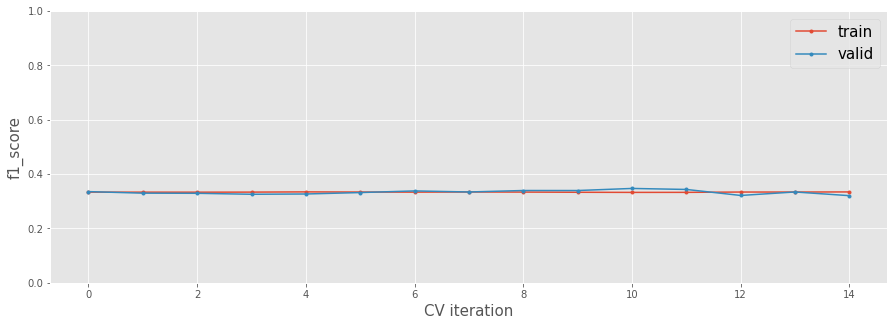

In [76]:
cv_metrics = cross_validate(model_0_bp_cv, X_0, y_0, cv=15, scoring='f1', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)

[train] f1_score = 0.7211 +/- 0.0006
[valid] f1_score = 0.7203 +/- 0.0101


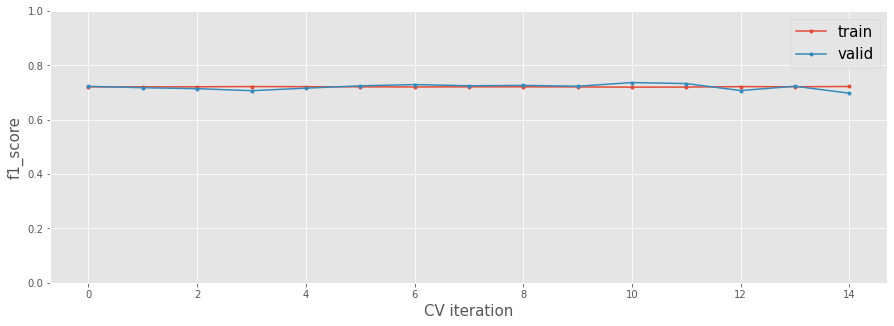

In [77]:
cv_metrics = cross_validate(model_0_bp_cv, X_0, y_0, cv=15, scoring='roc_auc', return_train_score=True, verbose=0)
plot_cv_metrics(cv_metrics)